In [1]:
import pandas as pd
import numpy as np
import pyspark
import pyspark.sql.functions as sqlfunc
from pyspark import ml
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Formatação das saídas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [3]:
conf = pyspark.SparkConf().setAppName('btc-jupyter').setMaster('spark://spark-master:7077')
sc = pyspark.SparkContext(conf=conf)
sc.setLogLevel('ERROR')
spark_session = pyspark.sql.SparkSession(sc)

/usr/local/lib/python3.9/dist-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/18 02:56:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Definindo semente aleatória (seed) para reprodutibilidade do notebook
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

In [5]:
df_spark = spark_session.read.csv('file:///opt/workspace/data/dataset.csv', header = 'true', inferSchema = 'true')
# Tipo do objeto
type(df_spark)

pyspark.sql.dataframe.DataFrame

In [6]:
df_spark.show()

+----------+----+----+----+-----+------------+-----------------+--------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+----+----+----+-----+------------+-----------------+--------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319660| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345100| NaN| NaN| NaN|  NaN|       

In [7]:
df_spark.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



#### Data Wrangling

In [8]:
df_spark.createOrReplaceGlobalTempView('dados_bitcoin')

In [9]:
df_bitcoin = spark_session.sql("select *, from_unixtime(Timestamp) as `dateTime` from global_temp.dados_bitcoin")
type(df_bitcoin)

pyspark.sql.dataframe.DataFrame

In [14]:
df_bitcoin=df_bitcoin.dropna('any')
df_bitcoin=df_bitcoin.withColumnRenamed("Volume_(BTC)", "vol-bitcoin")\
                     .withColumnRenamed("Volume_(Currency)", "vol-currency")\
                     .withColumnRenamed('Open','open')\
                     .withColumnRenamed('High','high')\
                     .withColumnRenamed('Low','low')\
                     .withColumnRenamed('Close','close')
#Spliting date and time in two other columns
df_data_hora = df_bitcoin.withColumn("date", sqlfunc.split(sqlfunc.col("dateTime"), " ").getItem(0))\
                         .withColumn("time", sqlfunc.split(sqlfunc.col("dateTime"), " ").getItem(1))

#Creating new coloumns for day, month, year, hour
df_data_hora = df_data_hora.withColumn("day", sqlfunc.split(sqlfunc.col("date"), "-").getItem(2))\
                           .withColumn("month", sqlfunc.split(sqlfunc.col("date"), "-").getItem(1))\
                           .withColumn("year", sqlfunc.split(sqlfunc.col("date"), "-").getItem(0))\
                           .withColumn("hour", sqlfunc.split(sqlfunc.col("time"), ":").getItem(0))
#Setting dtypes
df_data_hora = df_data_hora.withColumn("date", df_data_hora["date"].cast(pyspark.sql.types.DateType()))\
                           .withColumn("hour", df_data_hora["hour"].cast(pyspark.sql.types.DoubleType()))\
                           .withColumn("dateTime", df_data_hora["dateTime"].cast(pyspark.sql.types.DateType()))
#Creating day_of_week col
df_data_hora = df_data_hora.withColumn('day_of_week',sqlfunc.dayofweek(df_data_hora.date))

#Droping unused columns
df_data_hora=df_data_hora.drop('Timestamp', 'dateTime', 'date')

#Reordering
df_data_hora=df_data_hora.select(['year','month','day','day_of_week','hour', 'time', 'open', 'high', 'low', 'close', 'vol-bitcoin', 'vol-currency', 'Weighted_Price'])                   
df_data_hora.show(2)

+----+-----+---+-----------+----+--------+----+----+----+-----+-----------+------------+--------------+
|year|month|day|day_of_week|hour|    time|open|high| low|close|vol-bitcoin|vol-currency|Weighted_Price|
+----+-----+---+-----------+----+--------+----+----+----+-----+-----------+------------+--------------+
|2011|   12| 31|          7| 7.0|07:52:00|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|
|2011|   12| 31|          7|15.0|15:50:00|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|
+----+-----+---+-----------+----+--------+----+----+----+-----+-----------+------------+--------------+
only showing top 2 rows



#### Análise exploratória

In [15]:
df_pandas = df_data_hora.toPandas()

/tmp/ipykernel_1406/3829164182.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_pandas.corr()


<Axes: >

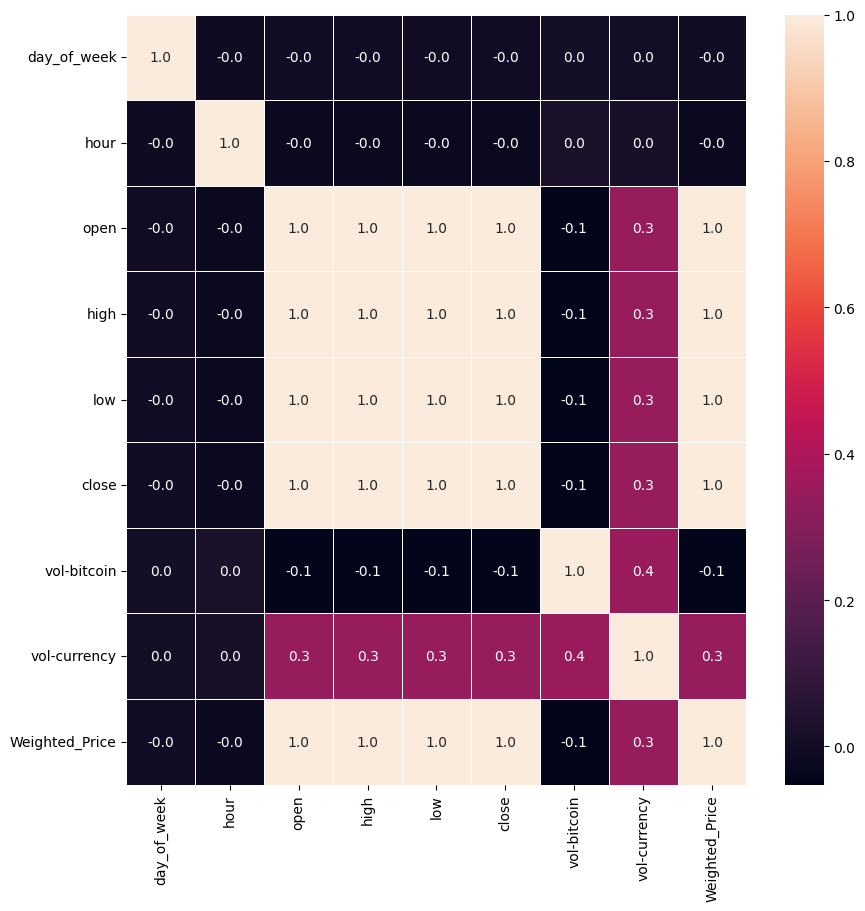

In [16]:
#Corr
corr = df_pandas.corr()
f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, linewidths=0.5,fmt='.1f', ax=ax)


<Figure size 1200x500 with 0 Axes>

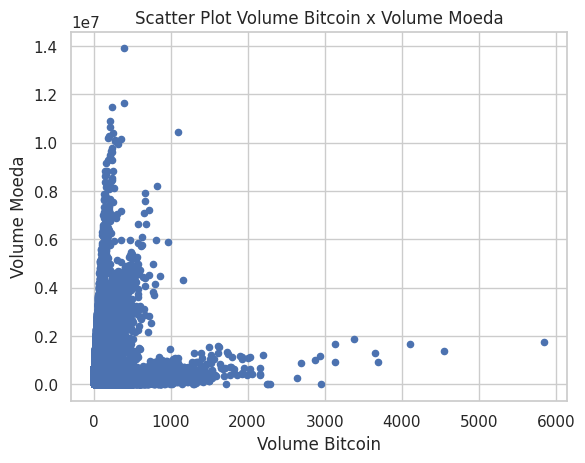

In [17]:
# Scatter Plot Volume Bitcoin x Volume Moeda
plt.figure(figsize = (12,5))
sns.set(style = 'whitegrid')
df_pandas.plot(kind = 'scatter', x = 'vol-bitcoin', y = 'vol-currency')
plt.xlabel('Volume Bitcoin')            
plt.ylabel('Volume Moeda')
plt.title('Scatter Plot Volume Bitcoin x Volume Moeda') 
plt.show()

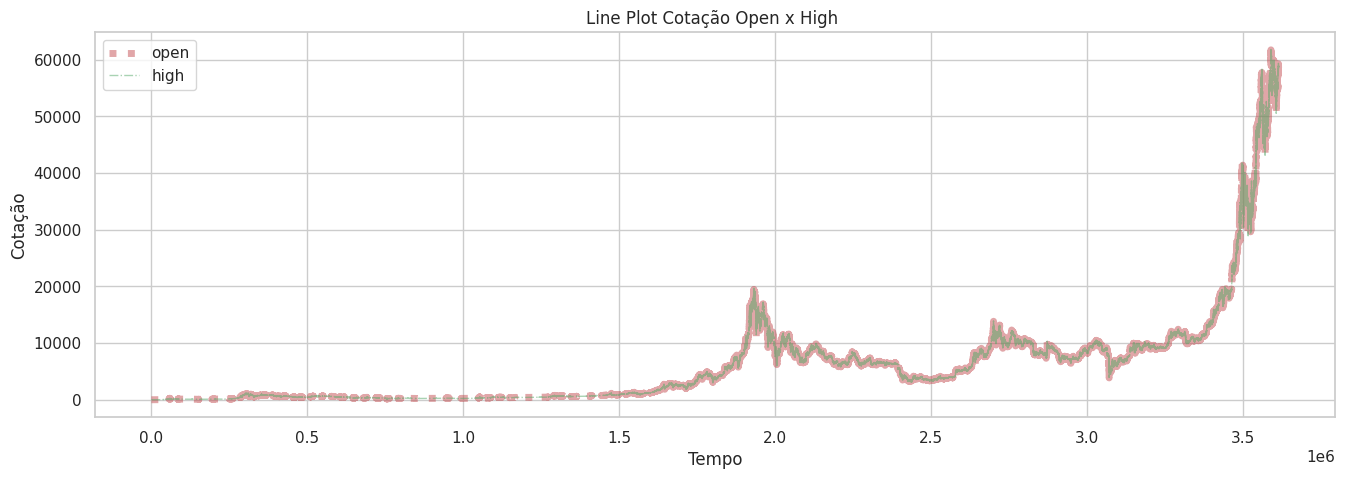

In [18]:
plt.figure(figsize = (16,5))
df_pandas.open.plot(kind = 'line', 
                    color = 'r', 
                    label = 'open', 
                    alpha = 0.5, 
                    linewidth = 5, 
                    grid = True, 
                    linestyle = ':')
df_pandas.high.plot(color = 'g', 
                    label = 'high', 
                    linewidth = 1, 
                    alpha = 0.5, 
                    grid = True, 
                    linestyle = '-.')
plt.legend(loc = 'upper left') 
plt.xlabel('Tempo')
plt.ylabel('Cotação')
plt.title('Line Plot Cotação Open x High ')
plt.show()

<Axes: ylabel='Frequency'>

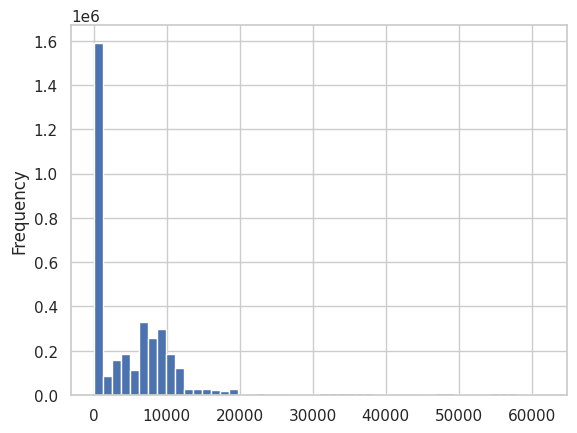

In [19]:
# Histograma da cotação de abertura
df_pandas.open.plot(kind = 'hist', bins = 50)

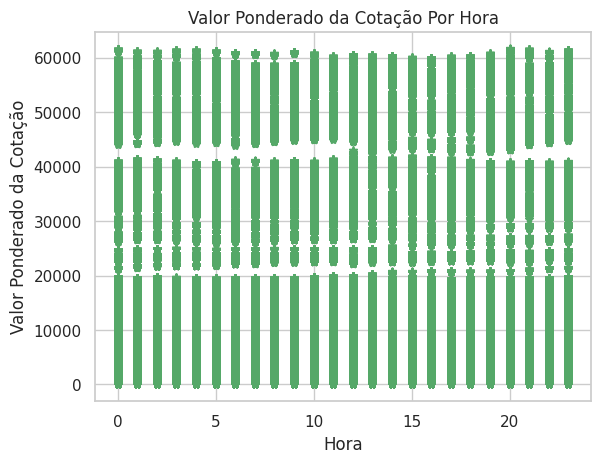

In [20]:
# Plot do valor ponderado da cotação (variável alvo) por hora
plt.plot(df_pandas.hour, df_pandas.Weighted_Price , 'g*')
plt.xlabel('Hora')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Hora') 
plt.show()

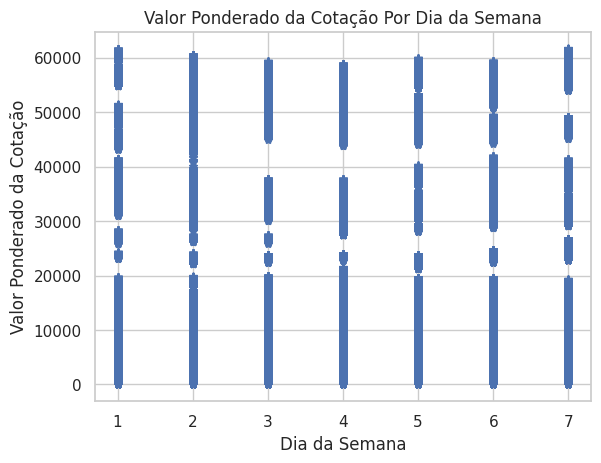

In [21]:
plt.plot(df_pandas.day_of_week, df_pandas.Weighted_Price, 'b*')
plt.xlabel('Dia da Semana')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Dia da Semana') 
plt.show()

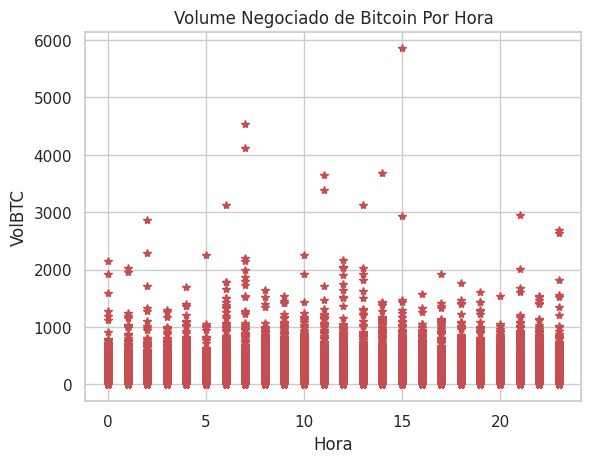

In [22]:
# Plot do VolBTC por hora
plt.plot(df_pandas.hour, df_pandas['vol-bitcoin'], 'r*')
plt.xlabel('Hora')            
plt.ylabel('VolBTC')
plt.title('Volume Negociado de Bitcoin Por Hora') 
plt.show()

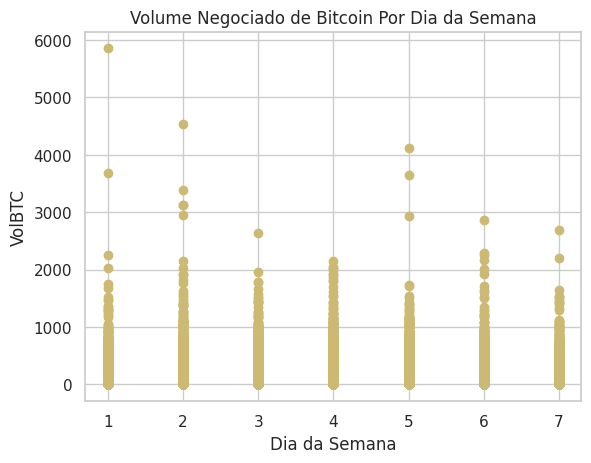

In [24]:
# Plot de VolBTC por dia da semana
plt.plot(df_pandas.day_of_week, df_pandas['vol-bitcoin'], 'yo')
plt.xlabel('Dia da Semana')            
plt.ylabel('VolBTC')
plt.title('Volume Negociado de Bitcoin Por Dia da Semana') 
plt.show()

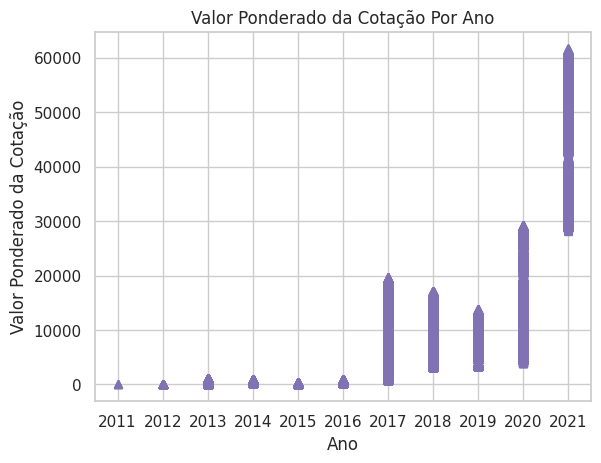

In [25]:
# Plot do valor ponderado da cotação por ano
plt.plot(df_pandas.year,df_pandas.Weighted_Price , 'm^')
plt.xlabel('Ano')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Ano') 
plt.show()

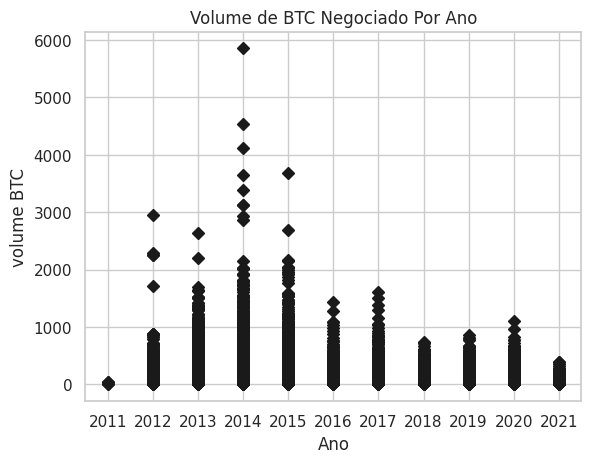

In [26]:
# Plot do Volume por ano
plt.plot(df_pandas.year, df_pandas['vol-bitcoin'] , 'kD')
plt.xlabel('Ano')            
plt.ylabel('volume BTC')
plt.title('Volume de BTC Negociado Por Ano') 
plt.show()

In [27]:
df_bitcoin.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- vol-bitcoin: double (nullable = true)
 |-- vol-currency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)



In [28]:
# Prepara o vetor de atributos
assembler = ml.feature.VectorAssembler(inputCols = ['open', 'vol-bitcoin', 'vol-currency'], 
                            outputCol = "features")

In [29]:
df_assembled = assembler.transform(df_bitcoin)
df_assembled.show(10, truncate = False)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|Timestamp |open|high|low |close|vol-bitcoin|vol-currency|Weighted_Price|dateTime           |features                      |
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|1325317920|4.39|4.39|4.39|4.39 |0.45558087 |2.0000000193|4.39          |2011-12-31 07:52:00|[4.39,0.45558087,2.0000000193]|
|1325346600|4.39|4.39|4.39|4.39 |48.0       |210.72      |4.39          |2011-12-31 15:50:00|[4.39,48.0,210.72]            |
|1325350740|4.5 |4.57|4.5 |4.57 |37.86229723|171.38033753|4.5264114983  |2011-12-31 16:59:00|[4.5,37.86229723,171.38033753]|
|1325350800|4.58|4.58|4.58|4.58 |9.0        |41.22       |4.58          |2011-12-31 17:00:00|[4.58,9.0,41.22]              |
|1325391360|4.58|4.58|4.58|4.58 |1.502      |6.87916     |4.58          |2012-01-01 04:16:00|[4.58,1.502,6.87916]          |


In [30]:
# Divisão em dados de treino e teste
dados_treino, dados_teste = df_assembled.randomSplit([.7,.3], seed = rnd_seed)

#Normalização
# Cria o scaler
scaler = ml.feature.MinMaxScaler(inputCol = "features", outputCol = "scaled_features")

# Fit nos dados de treino
scalerModel = scaler.fit(dados_treino)

# Fit e transform nos dados de treino
dados_treino_scaled = scalerModel.transform(dados_treino)

# Transform nos dados de teste
dados_teste_scaled = scalerModel.transform(dados_teste)

In [31]:
dados_treino_scaled.select("features", "scaled_features").show(10, truncate = False)

+-------------------------------+-------------------------------------------------------------------+
|features                       |scaled_features                                                    |
+-------------------------------+-------------------------------------------------------------------+
|[4.39,48.0,210.72]             |[9.557729822093386E-6,0.008199728766573702,1.51589789206087E-5]    |
|[4.5,37.86229723,171.38033753] |[1.1339679449941311E-5,0.006467928495112392,1.2328924278777876E-5] |
|[4.58,9.0,41.22]               |[1.263564281564889E-5,0.001537449143732569,2.9653241795154263E-6]  |
|[4.84,10.0,48.4]               |[1.6847523754198516E-5,0.001708276826369521,3.4818459555688167E-6] |
|[5.0,10.1,50.5]                |[1.9439450485613674E-5,0.0017253595946332162,3.63291778421953E-6]  |
|[5.14,0.68,3.4952]             |[2.170738637560193E-5,1.1616282419312745E-4,2.5144107404760596E-7] |
|[5.26,29.31939163,154.21999997]|[2.36513314241633E-5,0.00500856372847815,1.109442

In [32]:
dados_treino_scaled.columns

['Timestamp',
 'open',
 'high',
 'low',
 'close',
 'vol-bitcoin',
 'vol-currency',
 'Weighted_Price',
 'dateTime',
 'features',
 'scaled_features']

In [33]:
# Cria o modelo de regressão
modelo_lr_v1 = (ml.regression.LinearRegression(featuresCol = 'scaled_features', 
                                 labelCol = "Weighted_Price", 
                                 predictionCol = 'Predicted_price', 
                                 maxIter = 100, 
                                 regParam = 0.3, 
                                 elasticNetParam = 0.8, 
                                 standardization = False))

In [34]:
# Treina o modelo
modelo_v1 = modelo_lr_v1.fit(dados_treino_scaled)

In [35]:
# Salva o modelo em disco
modelo_v1.write().overwrite().save("file:///opt/workspace/data/model") 